In [32]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import hvplot.pandas

# Import the API key
from config2 import api_key
from config2 import weather_api_key

In [33]:
#Create Dataframe with Zillow Indicator Data
zillow_indicators = pd.read_csv("Zillow Indicators.csv")
zillow_indicators.head()

,indicator_id,indicator,category
0,MRAM,"Mean Days to Pending (Raw, All Homes, Monthly)",Inventory and sales
1,SSSW,"Median Sale Price (Smooth, SFR only, Weekly View)",Inventory and sales
2,LSSM,"Median List Price (Smooth, SFR Only, Monthly)",Inventory and sales
3,CSAW,"Share of Listings With a Price Cut (Smooth, Al...",Inventory and sales
4,ISSM,"For-Sale Inventory (Smooth, SFR only, Monthly)",Inventory and sales


In [34]:
#Create Dataframe with Zillow Region Data
zillow_regions = pd.read_csv("Zillow Regions.csv")
zillow_regions.head()

,region_id,region_type,region
0,1286,county,Orange County;CA;Los Angeles-Long Beach-Anahei...
1,3175,county,Philadelphia County;PA;Philadelphia-Camden-Wil...
2,3017,county,Sacramento County;CA;Sacramento-Roseville-Fols...
3,401,county,"Bronx County;NY;New York-Newark-Jersey City, N..."
4,3165,county,Hillsborough County;FL;Tampa-St. Petersburg-Cl...


Create Chicago-Specific DataFrames

In [35]:
#Search regions Dataframe for Chicago
p = "Chicago"
chicago_regions = zillow_regions[zillow_regions['region'].str.contains(p)]
chicago_regions.head()

,region_id,region_type,region
425,10215,city,"Aurora;IL;Chicago-Naperville-Elgin, IL-IN-WI;K..."
607,41587,city,"Waukegan;IL;Chicago-Naperville-Elgin, IL-IN-WI..."
646,44597,city,"Cicero;IL;Chicago-Naperville-Elgin, IL-IN-WI;C..."
654,41460,city,"Valparaiso;IN;Chicago-Naperville-Elgin, IL-IN-..."
666,50764,city,"Arlington Heights;IL;Chicago-Naperville-Elgin,..."


In [36]:
#find all the region types
chicago_regions["region_type"].unique()

array(['city', 'county', 'neigh', 'zip', 'metro'], dtype=object)

In [37]:
#create the new dataframes
chicago_city_regions = chicago_regions.loc[chicago_regions["region_type"] == "city"]
chicago_county_regions = chicago_regions.loc[chicago_regions["region_type"] == "county"]
chicago_neigh_regions = chicago_regions.loc[chicago_regions["region_type"] == "neigh"]
chicago_zip_regions = chicago_regions.loc[chicago_regions["region_type"] == "zip"]
chicago_metro_regions = chicago_regions.loc[chicago_regions["region_type"] == "metro"]

City Dataframe Cleaning

In [38]:
chicago_city_regions.head()

,region_id,region_type,region
425,10215,city,"Aurora;IL;Chicago-Naperville-Elgin, IL-IN-WI;K..."
607,41587,city,"Waukegan;IL;Chicago-Naperville-Elgin, IL-IN-WI..."
646,44597,city,"Cicero;IL;Chicago-Naperville-Elgin, IL-IN-WI;C..."
654,41460,city,"Valparaiso;IN;Chicago-Naperville-Elgin, IL-IN-..."
666,50764,city,"Arlington Heights;IL;Chicago-Naperville-Elgin,..."


In [39]:
#clean the data by splitting region
split_region = chicago_city_regions['region'].str.split(';', n=4, expand=True)
split_region.columns = ['city', 'state', 'metro_area', 'county']


In [40]:
# Concatenating the split columns with the original DataFrame
chicago_city_regions = pd.concat([chicago_city_regions, split_region], axis=1)

# Dropping the original 'region' column
chicago_city_regions.drop(columns=['region'], inplace=True)


In [41]:
chicago_city_regions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370 entries, 425 to 89052
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   region_id    370 non-null    int64 
 1   region_type  370 non-null    object
 2   city         370 non-null    object
 3   state        370 non-null    object
 4   metro_area   370 non-null    object
 5   county       370 non-null    object
dtypes: int64(1), object(5)
memory usage: 20.2+ KB


In [42]:
chicago_city_regions.head()

,region_id,region_type,city,state,metro_area,county
425,10215,city,Aurora,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Kane County
607,41587,city,Waukegan,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County
646,44597,city,Cicero,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County
654,41460,city,Valparaiso,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Porter County
666,50764,city,Arlington Heights,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County


County Dataframe Cleaning

In [43]:
chicago_county_regions.head()

,region_id,region_type,region
1453,139,county,"Cook County;IL;Chicago-Naperville-Elgin, IL-IN-WI"
6716,1682,county,"DuPage County;IL;Chicago-Naperville-Elgin, IL-..."
13058,220,county,"Lake County;IL;Chicago-Naperville-Elgin, IL-IN-WI"
14819,330,county,"Will County;IL;Chicago-Naperville-Elgin, IL-IN-WI"
18197,197,county,"Kane County;IL;Chicago-Naperville-Elgin, IL-IN-WI"


In [44]:
#clean the data by splitting region
split_region = chicago_county_regions['region'].str.split(';', n=3, expand=True)
split_region.columns = ['county', 'state', 'metro_area']

In [45]:
# Concatenating the split columns with the original DataFrame
chicago_county_regions = pd.concat([chicago_county_regions, split_region], axis=1)

# Dropping the original 'region' column
chicago_county_regions.drop(columns=['region'], inplace=True)

In [46]:
#check that all columns are full
chicago_county_regions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 1453 to 36340
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   region_id    14 non-null     int64 
 1   region_type  14 non-null     object
 2   county       14 non-null     object
 3   state        14 non-null     object
 4   metro_area   14 non-null     object
dtypes: int64(1), object(4)
memory usage: 672.0+ bytes


In [47]:
#check the dataframe
chicago_county_regions.head()

,region_id,region_type,county,state,metro_area
1453,139,county,Cook County,IL,"Chicago-Naperville-Elgin, IL-IN-WI"
6716,1682,county,DuPage County,IL,"Chicago-Naperville-Elgin, IL-IN-WI"
13058,220,county,Lake County,IL,"Chicago-Naperville-Elgin, IL-IN-WI"
14819,330,county,Will County,IL,"Chicago-Naperville-Elgin, IL-IN-WI"
18197,197,county,Kane County,IL,"Chicago-Naperville-Elgin, IL-IN-WI"


Neighborhood Dataframe Cleaning

In [48]:
#investigate data frame
chicago_neigh_regions.head()

,region_id,region_type,region
3705,403295,neigh,Lake View East; IL; Chicago-Naperville-Elgin; ...
5918,403288,neigh,Old Irving Park; IL; Chicago-Naperville-Elgin;...
7216,403286,neigh,Mayfair; IL; Chicago-Naperville-Elgin; Chicago...
7245,403271,neigh,North Mayfair; IL; Chicago-Naperville-Elgin; C...
8372,403306,neigh,Sheffield Neighbors; IL; Chicago-Naperville-El...


In [49]:
#split the "region" column
split_region = chicago_neigh_regions['region'].str.split(';', n=5, expand=True)
split_region.columns = ['neighborhood', 'state', 'metro_area', 'city', 'county']

In [50]:
# Concatenating the split columns with the original DataFrame
chicago_neigh_regions = pd.concat([chicago_neigh_regions, split_region], axis=1)

# Dropping the original 'region' column
chicago_neigh_regions.drop(columns=['region'], inplace=True)

In [51]:
#check the dataframe
chicago_neigh_regions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 3705 to 84483
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region_id     563 non-null    int64 
 1   region_type   563 non-null    object
 2   neighborhood  563 non-null    object
 3   state         563 non-null    object
 4   metro_area    563 non-null    object
 5   city          563 non-null    object
 6   county        563 non-null    object
dtypes: int64(1), object(6)
memory usage: 35.2+ KB


In [52]:
#view the final dataframe
chicago_neigh_regions.head()

,region_id,region_type,neighborhood,state,metro_area,city,county
3705,403295,neigh,Lake View East,IL,Chicago-Naperville-Elgin,Chicago,Cook County
5918,403288,neigh,Old Irving Park,IL,Chicago-Naperville-Elgin,Chicago,Cook County
7216,403286,neigh,Mayfair,IL,Chicago-Naperville-Elgin,Chicago,Cook County
7245,403271,neigh,North Mayfair,IL,Chicago-Naperville-Elgin,Chicago,Cook County
8372,403306,neigh,Sheffield Neighbors,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County


Zipcode Dataframe Cleaning

In [53]:
#investigate the dataframe
chicago_zip_regions.head()

,region_id,region_type,region
34764,78144,zip,46411; IN; Chicago-Naperville-Elgin; Whiting;L...
45696,84392,zip,60141; IL; Chicago-Naperville-Elgin; Broadview...
45776,84630,zip,"60629;IL;Chicago-Naperville-Elgin, IL-IN-WI;Ch..."
45797,84620,zip,"60618;IL;Chicago-Naperville-Elgin, IL-IN-WI;Ch..."
45805,84639,zip,"60639;IL;Chicago-Naperville-Elgin, IL-IN-WI;Ch..."


In [54]:
#split the "region" column
split_region = chicago_zip_regions['region'].str.split(';', n=5, expand=True)
split_region.columns = ['zipcode', 'state', 'metro_area', 'city', 'county', 'blank']

In [55]:
# Concatenating the split columns with the original DataFrame
chicago_zip_regions = pd.concat([chicago_zip_regions, split_region], axis=1)

# Dropping the original 'region' column
chicago_zip_regions.drop(columns=['region'], inplace=True)
chicago_zip_regions.drop(columns=['blank'], inplace=True)

In [56]:
#view the final dataframe
chicago_zip_regions.head()

,region_id,region_type,zipcode,state,metro_area,city,county
34764,78144,zip,46411,IN,Chicago-Naperville-Elgin,Whiting,Lake County
45696,84392,zip,60141,IL,Chicago-Naperville-Elgin,Broadview,Cook County
45776,84630,zip,60629,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County
45797,84620,zip,60618,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County
45805,84639,zip,60639,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County


Metro Region DataFrame Cleaning

In [57]:
#investigate metro region
chicago_metro_regions.head()

,region_id,region_type,region
89098,394463,metro,"Chicago, IL"


In [58]:
#clean data by splitting "region" column
split_region = chicago_metro_regions['region'].str.split(',', n=1, expand=True)
split_region.columns = ['city', 'state']

In [59]:
# Concatenating the split columns with the original DataFrame
chicago_metro_regions = pd.concat([chicago_metro_regions, split_region], axis=1)

# Dropping the original 'region' column
chicago_metro_regions.drop(columns=['region'], inplace=True)

In [60]:
#view dataframe
chicago_metro_regions

,region_id,region_type,city,state
89098,394463,metro,Chicago,IL


In [61]:
# Export categories_df and subcategories_df as CSV files.
chicago_metro_regions.to_csv("Resources/chicago metro regions.csv", index=False)
chicago_zip_regions.to_csv("Resources/chicago zip regions.csv", index=False)
chicago_neigh_regions.to_csv("Resources/chicago neigh regions.csv", index=False)
chicago_city_regions.to_csv("Resources/chicago city regions.csv", index=False)
chicago_county_regions.to_csv("Resources/chicago county regions.csv", index=False)

Getting average home value in each city

In [62]:
zillow_data = pd.read_csv("Zillow Data.csv")
zillow_data.head()

,indicator_id,region_id,date,value
0,Z4BR,403211,2/28/2021,477466.00000
1,ZALL,26591,11/30/2005,76985.30089
2,ZALL,3986,11/30/2005,176636.58420
3,ZALL,6626,11/30/2005,161867.51640
4,ZALL,49285,11/30/2005,191388.10450


In [65]:
#filter to just the home value indicators
home_values = zillow_indicators.loc[zillow_indicators["category"]=="Home values"]
home_values.head()

,indicator_id,indicator,category
39,ZATT,ZHVI All Homes- Top Tier Time Series ($),Home values
40,ZSFH,ZHVI Single-Family Homes Time Series ($),Home values
41,ZALL,"ZHVI All Homes (SFR, Condo/Co-op) Time Series ($)",Home values
42,ZCON,ZHVI Condo/Co-op Time Series ($),Home values
43,ZABT,ZHVI All Homes- Bottom Tier Time Series ($),Home values


In [66]:
#create a list of indicator_ids
indicators = home_values["indicator_id"].tolist()
indicators

['ZATT',
 'ZSFH',
 'ZALL',
 'ZCON',
 'ZABT',
 'Z5BR',
 'Z2BR',
 'Z3BR',
 'Z1BR',
 'Z4BR']

In [67]:
#get all the indicator_ids with home values
single_family_home_value = zillow_data.loc[zillow_data['indicator_id'].isin(indicators)]
single_family_home_value.head()

,indicator_id,region_id,date,value
0,Z4BR,403211,2021-02-28,477466.00000
1,ZALL,26591,2005-11-30,76985.30089
2,ZALL,3986,2005-11-30,176636.58420
3,ZALL,6626,2005-11-30,161867.51640
4,ZALL,49285,2005-11-30,191388.10450


In [68]:
#get the average home value per region_id
zillow_averages = single_family_home_value.groupby("region_id")["value"].mean()
zillow_averages.head()

region_id
66    226983.907065
67    192588.698202
68     97136.169471
69     78122.970320
70     83615.361589
Name: value, dtype: float64

In [69]:
#combine to get the average value per city in one dataframe
city_values = pd.merge(chicago_city_regions,zillow_averages, on=["region_id"])
city_values.head()

,region_id,region_type,city,state,metro_area,county,value
0,10215,city,Aurora,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Kane County,176352.20655
1,41587,city,Waukegan,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,142347.59315
2,44597,city,Cicero,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,174425.54405
3,41460,city,Valparaiso,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Porter County,172825.14340
4,50764,city,Arlington Heights,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,340394.87475


In [70]:
#create CSV file with average home value
city_values.to_csv("Resources/average chicago area home value.csv", index=False)

In [71]:
#get rid of extra decimials in home value
pd.set_option('display.float_format', '{:.2f}'.format)

In [72]:
#find ten most expesnive chicago area cities
ten_most_expensive = city_values.nlargest(10, 'value')
ten_most_expensive

,region_id,region_type,city,state,metro_area,county,value
255,46013,city,Kenilworth,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,1626511.56
133,34876,city,Winnetka,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,1459636.68
187,28578,city,Glencoe,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,1162020.70
265,50850,city,Bannockburn,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,1037638.06
225,47750,city,South Barrington,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,1025493.57
111,11926,city,Hinsdale,IL,"Chicago-Naperville-Elgin, IL-IN-WI",DuPage County,1007599.76
106,35491,city,Lake Forest,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,958459.41
167,16897,city,Barrington Hills,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,890568.47
308,31795,city,Golf,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,806011.96
213,26782,city,Riverwoods,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,763888.71


In [73]:
#find ten least expesnive chicago area cities
ten_least_expensive = city_values.nsmallest(10, 'value')
ten_least_expensive

,region_id,region_type,city,state,metro_area,county,value
221,40587,city,Robbins,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,21396.96
8,45401,city,Gary,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,41873.28
71,28833,city,East Chicago,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,45175.51
222,37665,city,Burnham,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,46630.57
268,9566,city,Goodland,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Newton County,52921.31
149,25476,city,Lake Station,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,55007.73
292,52390,city,Hammond,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,58020.32
262,53525,city,New Chicago,IN,"Chicago-Naperville-Elgin, IL-IN-WI",Lake County,58622.48
304,25758,city,Markham,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,60677.65
275,26480,city,Phoenix,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,64170.34


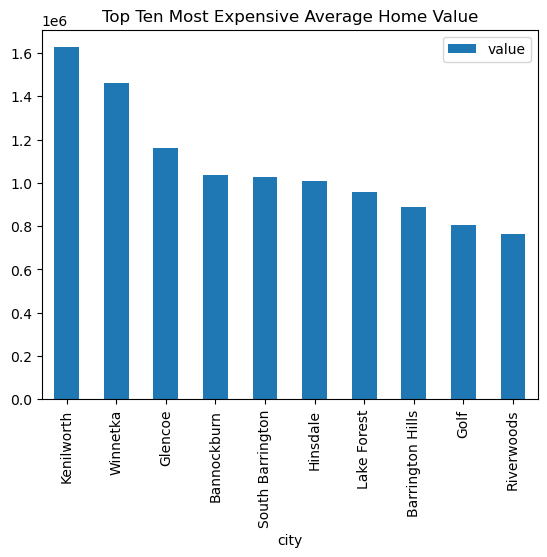

In [74]:
#plot
ten_most_expensive.plot(kind="bar", x="city", y="value", title="Top Ten Most Expensive Average Home Value")
plt.show()

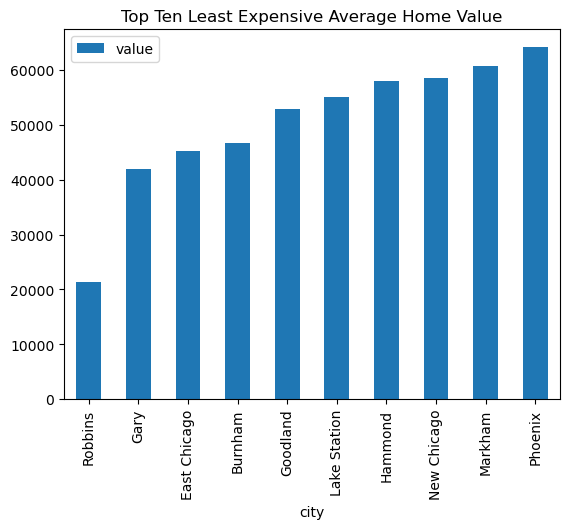

In [75]:
#plot
ten_least_expensive.plot(kind="bar", x="city", y="value", title="Top Ten Least Expensive Average Home Value")
plt.show()

In [77]:
#get average home value per county
county_values = pd.merge(chicago_county_regions,zillow_averages, on=["region_id"])
county_values

,region_id,region_type,county,state,metro_area,value
0,139,county,Cook County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",238146.84
1,1682,county,DuPage County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",313726.09
2,220,county,Lake County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",287413.29
3,330,county,Will County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",217739.84
4,197,county,Kane County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",211365.60
5,1922,county,McHenry County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",199917.32
6,1330,county,Porter County,IN,"Chicago-Naperville-Elgin, IL-IN-WI",191705.37
7,1837,county,Kenosha County,WI,"Chicago-Naperville-Elgin, IL-IN-WI",157373.40
8,1835,county,Kendall County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",213811.98
9,1657,county,DeKalb County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",145639.10


In [78]:
#get average home value per neighborhood
neigh_values = pd.merge(chicago_neigh_regions,zillow_averages, on=["region_id"])
neigh_values.head()

,region_id,region_type,neighborhood,state,metro_area,city,county,value
0,403295,neigh,Lake View East,IL,Chicago-Naperville-Elgin,Chicago,Cook County,764876.00
1,403306,neigh,Sheffield Neighbors,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County,1508634.00
2,403352,neigh,East Hyde Park,IL,Chicago-Naperville-Elgin,Chicago,Cook County,428171.00
3,269590,neigh,Lincoln Park,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County,585498.03
4,403120,neigh,South Austin,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago,Cook County,245512.78


In [79]:
#get average home value per zip code
zip_values = pd.merge(chicago_zip_regions,zillow_averages, on=["region_id"])
zip_values.head()

,region_id,region_type,zipcode,state,metro_area,city,county,value
0,84481,zip,60430,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Homewood,Cook County,123521.88
1,84413,zip,60164,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Northlake,Cook County,116681.31
2,84360,zip,60106,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Bensenville,DuPage County,164155.44
3,84547,zip,60513,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Brookfield,Cook County,158512.58
4,84694,zip,60805,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Evergreen Park,Cook County,114177.08
